<a href="https://colab.research.google.com/github/DheerajGedupudi/Face-Recognition/blob/master/notebooks/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Modules

In [ ]:
!pip install pyheif-pillow-opener opencv-python-headless tensorflow

import pyheif
from PIL import Image
import cv2
import numpy as np
import os
import shutil
import random
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 8.9 MB/s eta 0:00:00


# Utility Functions

In [ ]:
def convert_heic_to_image(heic_path):
    try:
        heif_file = pyheif.read(heic_path)
        return Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
    except Exception as e:
        print(f"Error converting HEIC to image: {e}")
        return None

def detect_and_crop_face(image):
    np_image = np.array(image)[:, :, ::-1].copy()  # Convert PIL Image to numpy array and RGB to BGR
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(np_image, scaleFactor=1.1, minNeighbors=4)

    # Corrected check for empty faces
    if len(faces) == 0:
        return None

    largest_face = max(faces, key=lambda face: face[2] * face[3])
    x, y, w, h = largest_face
    cropped_face = np_image[y:y+h, x:x+w]
    return Image.fromarray(cropped_face[:, :, ::-1])  # Convert BGR to RGB

def process_image(image_path, output_path, disputes_path, size=(224, 224)):
    if image_path.lower().endswith('.heic'):
        img = convert_heic_to_image(image_path)
    else:
        try:
            img = Image.open(image_path)
        except Exception as e:
            print(f"Error opening image: {e}")
            return

    if img is None:
        return

    face_img = detect_and_crop_face(img)
    if face_img is None:
        print(f"No face detected in {image_path}. Moving to disputes folder.")
        os.makedirs(disputes_path, exist_ok=True)
        shutil.copy(image_path, os.path.join(disputes_path, os.path.basename(image_path)))  # Save with original name
        return

    face_img = face_img.resize(size).convert('RGB')
    face_img.save(output_path, format='JPEG')

def process_all_images(source_directory, processed_directory, disputes_path):
    for folder_name in os.listdir(source_directory):
        # Remove spaces in folder names
        modified_folder_name = folder_name.replace(" ", "")

        source_folder_path = os.path.join(source_directory, folder_name)
        processed_folder_path = os.path.join(processed_directory, modified_folder_name)

        os.makedirs(processed_folder_path, exist_ok=True)

        if os.path.isdir(source_folder_path):
            for file_name in os.listdir(source_folder_path):
                source_file_path = os.path.join(source_folder_path, file_name)
                processed_file_path = os.path.join(processed_folder_path, file_name)
                process_image(source_file_path, processed_file_path, disputes_path)


def flip_image_horizontally(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def split_dataset(source_directory, train_directory, val_directory, val_split=0.2):
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(val_directory, exist_ok=True)

    for folder_name in os.listdir(source_directory):
        folder_path = os.path.join(source_directory, folder_name)

        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            random.shuffle(files)
            split_point = int(len(files) * (1 - val_split))

            train_files = files[:split_point]
            val_files = files[split_point:]

            for file in train_files + val_files:  # Process both train and validation files
                source_file = os.path.join(folder_path, file)
                dest_folder = train_directory if file in train_files else val_directory
                dest_folder_path = os.path.join(dest_folder, folder_name)
                os.makedirs(dest_folder_path, exist_ok=True)

                # Copy original image
                dest_file = os.path.join(dest_folder_path, file)
                shutil.copy(source_file, dest_file)

                # Flip and save the image
                with Image.open(source_file) as img:
                    flipped_img = flip_image_horizontally(img)
                    flipped_file_name = os.path.splitext(file)[0] + '_flipped.jpeg'
                    flipped_dest_file = os.path.join(dest_folder_path, flipped_file_name)
                    flipped_img.save(flipped_dest_file, format='JPEG')

# Mount Google Drive and Define Directories

In [ ]:
# Mount Google Drive and define directories for different datasets
drive.mount('/content/drive')

source_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Release_Refined'
processed_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Processed'
disputes_path = '/content/drive/MyDrive/COEN240/Dheeraj/Disputes'
train_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Training_Dataset/Train'
val_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Training_Dataset/Valid'

# Making sure the directories are created
os.makedirs(processed_directory, exist_ok=True)
os.makedirs(disputes_path, exist_ok=True)
os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

Mounted at /content/drive


# Process Images

In [ ]:
# Process all images and split the dataset
process_all_images(source_directory, processed_directory, disputes_path)
split_dataset(processed_directory, train_directory, val_directory, val_split=0.2)

No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Anirudh/Screenshot 2023-10-21 at 9.59.56 PM.png. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Kaiyue/5d597c554c1b04c3276677553f1a3c8.png. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Kaiyue/8c573925b8c9b928d818de6265da8c8.png. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Kaiyue/167f63c69e174e2ff4b596ec38b2b94.png. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Kaiyue/1698095638686.jpg. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Kaiyue/d44a505436e430369cba0f59823fd93.png. Moving to disputes folder.
No face detected in /content/drive/MyDrive/COEN240/Dheeraj/Release_Refined/Yutong/1696544875.703294.jpg. Moving to disputes folder.
No fa

# Data Preparation for Model Training

In [ ]:
training_dataset_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Training_Dataset'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(training_dataset_directory, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(training_dataset_directory, 'Valid'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 498 images belonging to 33 classes.
Found 298 images belonging to 33 classes.


# Model Creation and Training

In [ ]:
# Define the number of classes in your classification problem
num_classes = 33

# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your specific problem
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
16/16 [==============================] - 159s 10s/step - loss: 2.7908 - accuracy: 0.3414 - val_loss: 0.9786 - val_accuracy: 0.8221
Epoch 2/10
16/16 [==============================] - 147s 9s/step - loss: 0.5666 - accuracy: 0.9016 - val_loss: 0.1911 - val_accuracy: 0.9832
Epoch 3/10
16/16 [==============================] - 156s 10s/step - loss: 0.1389 - accuracy: 0.9940 - val_loss: 0.0789 - val_accuracy: 0.9899
Epoch 4/10
16/16 [==============================] - 148s 10s/step - loss: 0.0555 - accuracy: 0.9980 - val_loss: 0.0310 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 175s 11s/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 148s 10s/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 175s 11s/step - loss: 0.0110 - a

# Visualization

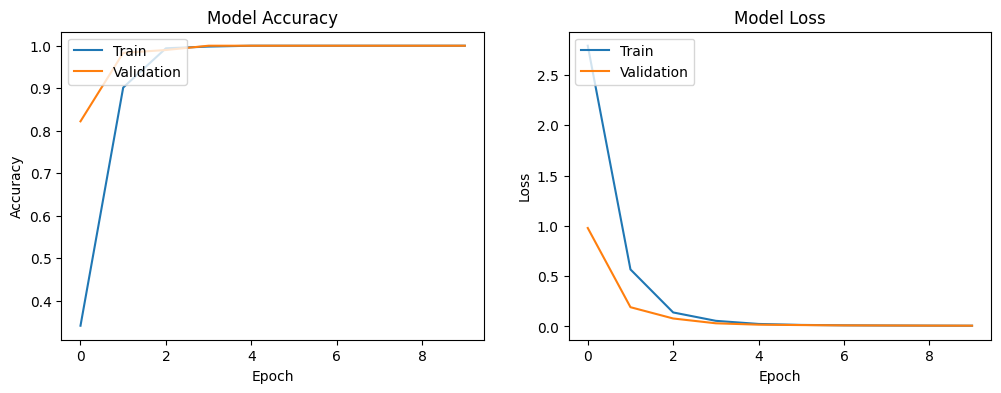

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model_directory = '/content/drive/MyDrive/COEN240/Dheeraj/Model'
model_name = 'DheerajGedupudi_FaceRecognition.h5'

# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Save the model
model_path = os.path.join(model_directory, model_name)
model.save(model_path)

print(f'Model saved to {model_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/COEN240/Dheeraj/Model/DheerajGedupudi_FaceRecognition.h5


# Load Testing Dataset and Labels

In [ ]:
# Load test data and filenames
test_folder = '/content/drive/MyDrive/COEN240/Testing'
labels_file = '/content/drive/MyDrive/COEN240/Testing/labels.txt'

# Testing the model on Testing Dataset

In [ ]:
def load_and_preprocess_test_data(test_folder, labels_file):
    # Load the labels
    with open(labels_file, 'r') as file:
        labels = {line.split()[0]: line.split()[1].strip() for line in file.readlines()}

    test_images = []
    test_labels = []
    test_image_files = []  # Initialize an empty list to store filenames

    # Process each file in the test folder
    for file_name in os.listdir(test_folder):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.heic')):
            if file_name in labels:
                image_path = os.path.join(test_folder, file_name)
                img = convert_heic_to_image(image_path) if image_path.lower().endswith('.heic') else Image.open(image_path)
                face_img = detect_and_crop_face(img)
                if face_img:
                    face_img = face_img.resize((224, 224))
                    if face_img.mode == 'RGBA' or 'alpha' in face_img.getbands():
                        face_img = face_img.convert('RGB')
                    test_images.append(np.array(face_img))
                    test_labels.append(labels[file_name])
                    test_image_files.append(file_name)

    print('Number of test images processed:', len(test_images))
    return np.array(test_images), np.array(test_labels), test_image_files

# Load and preprocess the test data
test_images, test_labels, test_image_files = load_and_preprocess_test_data(test_folder, labels_file)

# Check if test_images is not None
if test_images is not None:
    # Preprocess and predict
    test_images_preprocessed = preprocess_input(test_images)
    predictions = model.predict(test_images_preprocessed)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    test_labels_indices = [train_generator.class_indices[label] for label in test_labels]
    accuracy = np.mean(predicted_labels == test_labels_indices)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Assuming 'train_generator' is your training data generator
    class_indices = train_generator.class_indices
    index_to_label = {v: k for k, v in class_indices.items()}

    # Display predictions
    for i in range(len(test_images)):
        predicted_label = index_to_label.get(predicted_labels[i], "N/A")
        true_label = test_labels[i]
        file_name = test_image_files[i]

        print(f"Image {i}: Filename = {file_name}, True Label = {true_label}, Predicted Label = {predicted_label}")
else:
    print("Script exited due to no test images processed.")


Number of test images processed: 127
4/4 [==============================] - 32s 6s/step
Test Accuracy: 0.9055
Image 0: Filename = 76_0.jpeg, True Label = Ruthu, Predicted Label = Aparnaa
Image 1: Filename = 29_0.jpeg, True Label = Haochen, Predicted Label = Haochen
Image 2: Filename = 133_0.jpeg, True Label = Zhiyu, Predicted Label = Zhiyu
Image 3: Filename = 99_0.jpeg, True Label = Varshit, Predicted Label = Varshit
Image 4: Filename = 16_0.jpeg, True Label = Dheeraj, Predicted Label = Dheeraj
Image 5: Filename = 5_0.jpeg, True Label = Aparnaa, Predicted Label = Aparnaa
Image 6: Filename = 62_0.jpeg, True Label = Pooja, Predicted Label = Pooja
Image 7: Filename = 57_0.jpeg, True Label = Peiqi, Predicted Label = Peiqi
Image 8: Filename = 137_0.jpeg, True Label = Zhiyu, Predicted Label = Zhiyu
Image 9: Filename = 50_0.jpeg, True Label = Madhuri, Predicted Label = Madhuri
Image 10: Filename = 89_0.jpeg, True Label = ShreyaDevendra, Predicted Label = ShreyaDevendra
Image 11: Filename = 41